**Importing the necessary packages**

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

**Reading the necessary datasets:**

In [ ]:
movie_data = pd.read_csv('indian_movie_dataset.csv')
user_data = pd.read_csv('user_dataset.csv')
review_data = pd.read_csv('large_movie_reviews.csv')

In [ ]:
print(pd.DataFrame(user_data))

       UserID    Username FavoriteGenre MostlyWatchedLanguage
0           1       User1         Drama                Telugu
1           2       User2        Sci-Fi                Telugu
2           3       User3        Action               Marathi
3           4       User4        Comedy                 Hindi
4           5       User5        Sci-Fi                 Hindi
...       ...         ...           ...                   ...
99995   99996   User99996        Sci-Fi                 Tamil
99996   99997   User99997         Drama               Marathi
99997   99998   User99998        Horror               Bengali
99998   99999   User99999         Drama               Marathi
99999  100000  User100000        Horror               Marathi

[100000 rows x 4 columns]


**Data Preprocessing**

In [ ]:
movie_data.dropna(inplace=True)

user_data.dropna(inplace=True)

review_data.dropna(inplace=True)

**Sentimental Analysis**

In [ ]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
review_data['SentimentScore'] = review_data['ReviewText'].apply(lambda x: sia.polarity_scores(x)['compound'])
positive_reviews = review_data[review_data['SentimentScore'] > 0]
negative_reviews = review_data[review_data['SentimentScore'] < 0]


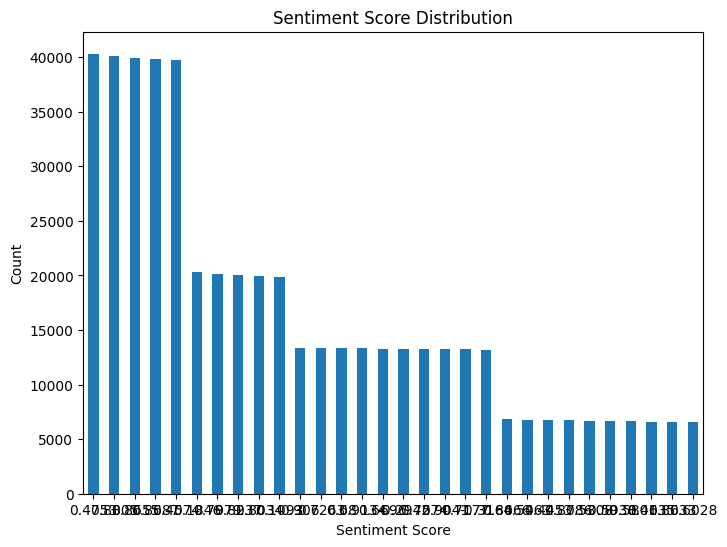

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have already calculated 'review_data' with sentiment scores

# Calculate the sentiment score distribution
sentiment_counts = review_data['SentimentScore'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar')
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

**Content Based Filtering**

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(movie_data['Genre'] + ' ' + movie_data['Language'])
content_cosine_similarity = cosine_similarity(tfidf_matrix, tfidf_matrix)

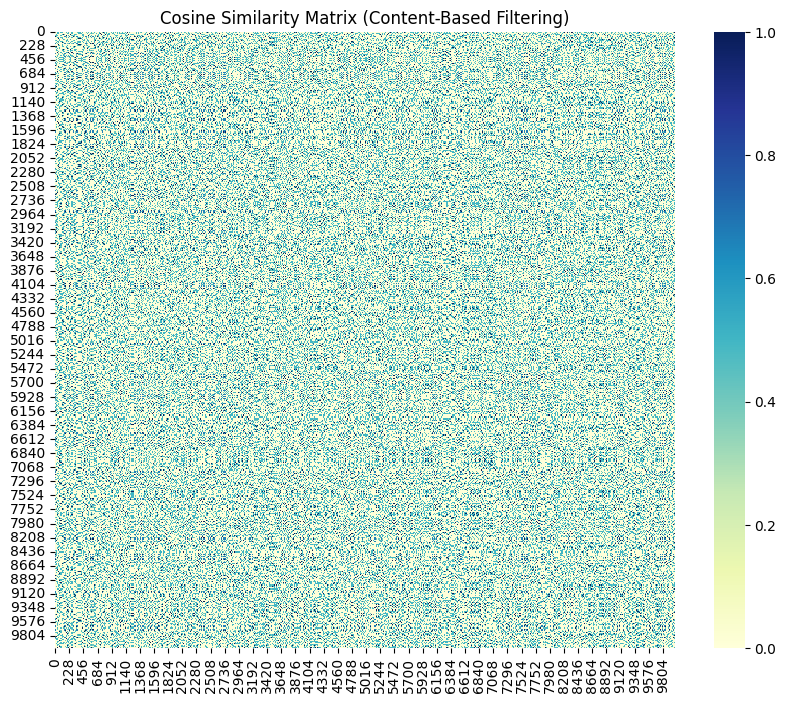

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have calculated the 'content_cosine_similarity' matrix (cosine similarity between movies based on genre and language)
# You can replace it with the correct variable name if needed.

# Plot the cosine similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(content_cosine_similarity, cmap='YlGnBu', annot=False)
plt.title('Cosine Similarity Matrix (Content-Based Filtering)')
plt.show()


**Collaborative Filtering**

In [ ]:
user_movie_matrix = review_data.pivot_table(index='UserID', columns='MovieID', values='SentimentScore', fill_value=0)
svd = TruncatedSVD(n_components=20)
svd.fit(user_movie_matrix)
collaborative_svd = pd.DataFrame(svd.transform(user_movie_matrix))

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error,mean_absolute_error

# Assuming you have already created the 'user_movie_matrix' and 'collaborative_svd' data structures
# user_movie_matrix: User-movie ratings matrix
# collaborative_svd: Collaborative filtering recommendations based on SVD

# Predict ratings using SVD
predicted_ratings = np.dot(collaborative_svd, svd.components_)

# Replace missing values with 0 (for unrated movies)
predicted_ratings[np.isnan(predicted_ratings)] = 0

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(user_movie_matrix, predicted_ratings))
mae = mean_absolute_error(user_movie_matrix, predicted_ratings)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 0.02078594351135187
MAE: 0.016526370358715677


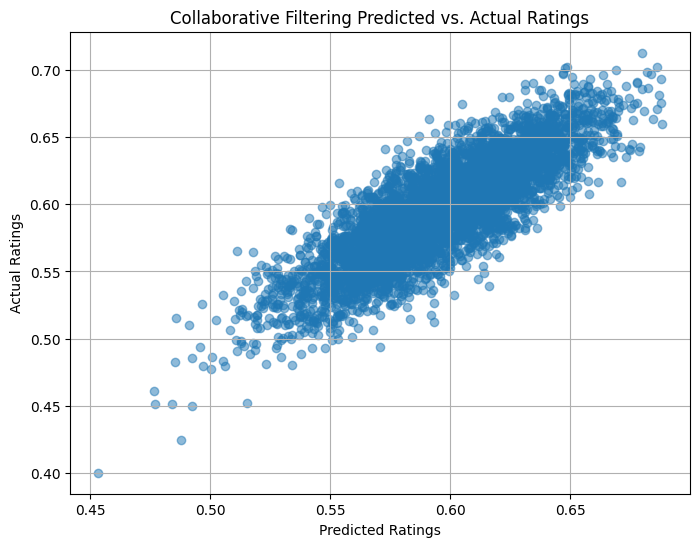

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have already calculated 'predicted_ratings' and 'user_movie_matrix'

# Flatten the predicted ratings and actual ratings
predicted_ratings_flat = predicted_ratings.flatten()
actual_ratings_flat = user_movie_matrix.values.flatten()

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(predicted_ratings_flat, actual_ratings_flat, alpha=0.5)
plt.title('Collaborative Filtering Predicted vs. Actual Ratings')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.grid(True)
plt.show()


**Hybrid Filtering**

In [ ]:
def hybrid_recommendation(user_id):
    # Get user's favorite genre and mostly watched language
    favorite_genre = user_data[user_data['UserID'] == user_id]['FavoriteGenre'].values[0]
    mostly_watched_language = user_data[user_data['UserID'] == user_id]['MostlyWatchedLanguage'].values[0]

    # Content-Based Recommendations
    content_recommendations = movie_data[
        (movie_data['Genre'].str.contains(favorite_genre)) &
        (movie_data['Language'] == mostly_watched_language)
    ]

    # Collaborative Filtering Recommendations
    user_svd = collaborative_svd.iloc[user_id - 1]
    collaborative_recommendations = movie_data.loc[user_svd.argsort()[::-1]]

    # Sentiment-Based Recommendations
    positive_sentiment_recommendations = movie_data[
        movie_data['MovieID'].isin(positive_reviews['MovieID'].tolist())
    ]
    negative_sentiment_recommendations = movie_data[
        movie_data['MovieID'].isin(negative_reviews['MovieID'].tolist())
    ]

    # Combine recommendations from different methods
    recommendations = {
        'ContentBased': content_recommendations,
        'CollaborativeFiltering': collaborative_recommendations,
        'PositiveSentiment': positive_sentiment_recommendations,
        'NegativeSentiment': negative_sentiment_recommendations,
    }

    # Here, you can implement your logic to combine the recommendations
    # For example, you can prioritize recommendations based on user preferences and sentiment analysis

    # In this example, we concatenate the recommendations from different methods
    combined_recommendations = pd.concat(recommendations.values()).drop_duplicates('MovieID')
    top_5_recommendations = combined_recommendations.head(5)[['Language', 'Title', 'ReleaseYear']]

    formatted_recommendations = ""
    for index, row in top_5_recommendations.iterrows():
      formatted_recommendations += f"{row['Title']} ({row['ReleaseYear']}) - Language: {row['Language']}\n"

    return formatted_recommendations

**Final Recommondation**

In [ ]:
user_id = 3
recommendations = hybrid_recommendation(user_id)

In [ ]:
print("Combined Recommendations:")
print(recommendations)

Combined Recommendations:
Movie 19 (1985) - Language: Marathi
Movie 34 (2000) - Language: Marathi
Movie 44 (2004) - Language: Marathi
Movie 119 (1985) - Language: Marathi
Movie 180 (2015) - Language: Marathi

